# <font style="color:blue">Project 1 - Part 2: Train an Image Classifier From Scratch</font>


As discussed in the previous notebook, the steps for training Neural Networks are:


* Step 1 - Understand your problem
* Step 2 - Dataset Exploration
    * Step 2A - Get the data
    * Step 2B - Explore & understand your data
    * Step 2C - Create a sample data from the dataset
* Step 3 - Data preparation
* Step 4 - Train a simple model on sample data, and check the pipeline before training the full network
* Step 5 - Train on full data
* Step 6 - Improve your model
* Step 7 - Generate Submission file

Follow Steps 1-4 exactly as you did in the previous notebook. Here, you will implement Steps 5, 6 & 7 from scratch.


**Design a model that achieves `>=80%` Public Test accuracy on the given dataset.**


This notebook carries **75** points out of a total of **100**. <font style="color:red">The sections which carry marks are in Red.</font>

#### Points Distribution - Maximum Points: 75


<div align="center">
    <table>
        <tr><td><h3>Number</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Configurations</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Model</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Confusion Matrix</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Submission File Generation</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Kaggle Submission Score</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


**After completing the project, upload and submit the notebook to the lab for feedback.**

**<font style="color:red">You need to achieve atleast 80% accuracy on the Public test leaderboard to successfully complete this project.</font>**


**<font style="color:red">Build your own model from scratch, and do not use any pre-trained models/weights.</font>**

# <font style="color:blue">Step 1: Understand Your problem </font><a name="step1"></a>
Already covered in the previous notebook.

In [52]:
!pip install graphviz
!pip install pydot

In [1]:
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from dataclasses import dataclass
import platform

# Text formatting
bold = "\033[1m"
end = "\033[0m"

block_plot=False

%matplotlib inline

2024-05-03 01:31:00.676207: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 01:31:00.676309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 01:31:00.815174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### <font style="color:green">Set Seeds</font>

Use this function to set random seeds for CPU and GPU operations in order to make training deterministic and to ensure reproducibility.

In [2]:
def set_seeds():
    # fix random seeds
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
    
    physical_devices = tf.config.list_physical_devices("GPU")
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass

    return

set_seeds()

In [3]:
# Creating a MirroredStrategy for distributed training.
# This strategy effectively replicates the model's layers on each GPU or other available devices,
# syncing their weights after each training step.
DISTRIBUTE_STRATEGY = tf.distribute.MirroredStrategy()

# <font style="color:blue">Step 2. Data Preparation</font>

### <font style="color:green">2.1.1. Dataset Configuration</font>

In [4]:
@dataclass
class DatasetConfig:
    DATA_ROOT: str = r"/kaggle/input/opencv-tf-project-1-image-classification-round-3/dataset"
    DATA_SHAPE: tuple = (224, 224, 3)
    NUM_CLASSES: int = 4

### <font style="color:green">2.1.2. Dataset Generation and Augmentation</font>

In [5]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomCrop, RandomContrast, RandomTranslation, RandomBrightness
from tensorflow.keras import Sequential

def data_augmentation_preprocess():
    data_augmentation_pipeline = Sequential([
#         RandomFlip("horizontal_vertical"),
#         RandomRotation(factor= 0.3),
#         RandomContrast(factor=0.3),
#         RandomZoom(height_factor=(0.2, 0.3), width_factor=(-0.3, -0.2)),
#         RandomTranslation(height_factor=(-0.2, 0.3), width_factor=(-0.2, 0.3))
  ])
    return data_augmentation_pipeline

def get_data(*, data_root, target_size=(224, 224), batch_size=32, data_augmentation=False):
    train_path = os.path.join(data_root, "Train")
    train_dataset = image_dataset_from_directory(
        train_path,
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=target_size,
        shuffle=True,
    )

    valid_path = os.path.join(data_root, "Valid")
    valid_dataset = image_dataset_from_directory(
        valid_path,
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=target_size,
        shuffle=True,
    )

    if data_augmentation:
        data_augmentation_pipeline = data_augmentation_preprocess()
        train_dataset = train_dataset.map(lambda x, y: (data_augmentation_pipeline(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

    return train_dataset, valid_dataset

# <font style="color:blue">Step 3: Dataset Exploration</font>

Found 3997 files belonging to 4 classes.
Found 786 files belonging to 4 classes.


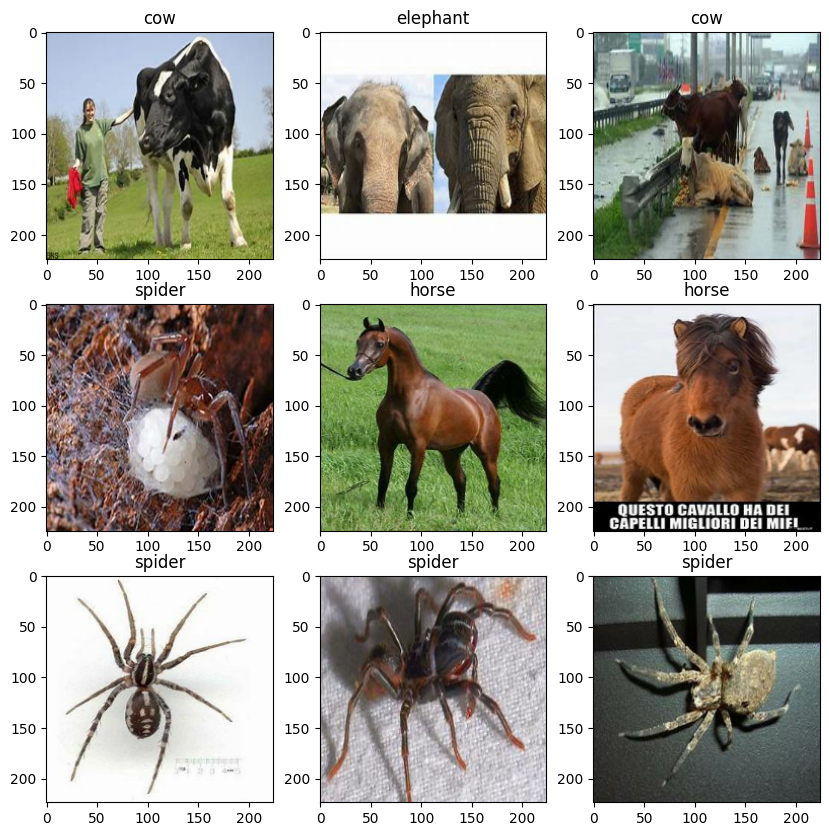

In [6]:
train_dataset, valid_dataset = get_data(data_root=DatasetConfig.DATA_ROOT,data_augmentation=False)
DatasetConfig.CLASS_NAMES = valid_dataset.class_names
train_batch_indice = random.randint(0, len(train_dataset))
valid_batch_indice = random.randint(0, len(valid_dataset))

plt.figure(figsize=(10, 10))
for image_batch, label_batch in train_dataset.take(train_batch_indice):
    train_images_indices = random.sample(range(0, len(image_batch)), 9)
    for index, data_index in enumerate(train_images_indices):
        plt.subplot(3, 3, index+1)
        plt.imshow(np.array(image_batch[data_index]).astype('uint8'))
        class_name = DatasetConfig.CLASS_NAMES[np.argmax(label_batch[data_index])]
        plt.title(class_name)
    break

# <font style="color:blue">Step 4: Train Your Model</font>

Now, create the training pipeline and train your model on the full data.

## <font style="color:red">4.1. Configurations [5 Points]</font>

To achieve good results, change the parameters given in these configurations.

### <font style="color:green">4.1.1. Training Configuration</font>

In [7]:
@dataclass
class TrainingConfig:
    # Defining the batch size for model training.
    # The batch size is set to be some integer times the  number of devices in synchronization as per the distributed strategy.
    # This means that the overall batch of data is divided equally across all the devices used in the distributed training.
    # By scaling the batch size with the number of replicas (devices), each device processes a batch of size, in this case, 4.
   
    # This approach helps in efficient utilization of the computational power of all the devices involved in training.
    BATCH_SIZE: int = 32 * DISTRIBUTE_STRATEGY.num_replicas_in_sync

    EPOCHS: int = 35
    LEARNING_RATE: float = 0.001

    # For tensorboard logging and saving checkpoints
    root_log_dir = os.path.join("Logs_Checkpoints", "Model_logs")
    root_checkpoint_dir = os.path.join("Logs_Checkpoints", "Model_checkpoints")

    # Current log and checkpoint directory.
    log_dir = "version_0"
    checkpoint_initial = "version_0"

    # Use multiprocessing during training.
    use_multiprocessing: bool = True if platform.system() == "Linux" else False
        
    # Number of workers to use for training.
    num_workers: int = 4

## <font style="color:blue">4.2. Callbacks</font>

Define the different callbacks you want to use during training.

In [8]:
def get_callbacks(
    training_config=TrainingConfig(),
    monitor="val_loss",
    mode="min",
    save_weights_only=False,
    save_best_only=True,
):

    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=training_config.log_dir,
        histogram_freq=20,
        write_graph=True,
        update_freq="epoch",
        write_images=True,
    )

    
    checkpoint_filepath = training_config.checkpoint_path
    
    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = os.path.join(checkpoint_filepath, "model.ckpt")
    else:
        checkpoint_filepath = os.path.join(checkpoint_filepath, "model.keras")

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=0,
    )
    
    return [tensorboard_callback, model_checkpoint_callback]

## <font style="color:blue">4.3. Logging Setup</font>

A function for initializing directories so that it saves tensorboard and model checkpoints for different training versions.

In [9]:
def setup_log_directory(training_config=TrainingConfig()):
    '''Tensorboard Log, Model checkpoint directory Setup and Early stopping'''
    
    get_number = lambda path: path.replace(".keras", "").replace("version_", "")
    
    if os.path.isdir(training_config.root_log_dir):
        # Get all folders numbers in the root_log_dir
        folder_numbers = [int(get_number(folder)) for folder in os.listdir(training_config.root_log_dir)]
        
        # Find the latest version number present in the log_dir
        last_version_number = max(folder_numbers)

        # New version name
        version_name = f"version_{last_version_number + 1}"

    else:
        version_name = training_config.log_dir


    # Update the training config default directory 
    training_config.log_dir        = os.path.join(training_config.root_log_dir,        version_name)
    training_config.checkpoint_path = os.path.join(training_config.root_checkpoint_dir, version_name)

    # Create new directory for saving new experiment version
    os.makedirs(training_config.log_dir, exist_ok=True)
    os.makedirs(training_config.root_checkpoint_dir, exist_ok=True)

    print(f"Logging at: {training_config.log_dir}")
    print(f"Model Checkpoint at: {training_config.checkpoint_path}")
    
    return training_config, version_name

## <font style="color:blue">4.4. Plot Loss and Accuracy</font>

Use this function to plot loss and accuracy for training and validation results.

In [10]:
def plot_history(
    train_loss=None,
    val_loss=None,
    train_metric=None,
    val_metric=None,
    colors=["blue", "green"],
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
    fig_size=(15, 10),
):

    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    fig.set_facecolor("white")

    # Loss Plots
    plt.subplot(2, 1, 1)

    train_loss_range = range(len(train_loss))
    plt.plot(
        train_loss_range,
        train_loss,
        color=f"tab:{colors[0]}",
        label=f"Train Loss",
    )

    valid_loss_range = range(len(val_loss))
    plt.plot(
        valid_loss_range,
        val_loss,
        color=f"tab:{colors[1]}",
        label=f"Valid Loss",
    )

    plt.ylabel("Loss")
    plt.legend(loc=loss_legend_loc)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.title("Training and Validation Loss")

    # Mean Average Precision Plots
    plt.subplot(2, 1, 2)

    train_metric_range = range(len(train_metric))
    plt.plot(
        train_metric_range,
        train_metric,
        color=f"tab:{colors[0]}",
        label=f"Train Accuracy",
    )

    val_metric_range = range(len(val_metric))
    plt.plot(
        val_metric_range,
        val_metric,
        color=f"tab:{colors[1]}",
        label=f"Valid Accuracy",
    )

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc=acc_legend_loc)
    plt.grid(True)
    plt.title("Training and Validation Accuracy")

    plt.show(block=block_plot)

    return

## <font style="color:red">4.5. Define Model [10 Points]</font>

**Next, define your CNN model.**

Keep iterating. Do this by training various models.

Experiment by changing the:

* Number of layers.
* Number of filters/units per layer.
* Different types of layers, e.g., dropout, batch normalization.
* Different combination of layers.

In [11]:
from keras import Model, layers, regularizers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, GlobalAveragePooling2D,
                          BatchNormalization, Flatten, Conv2D, SeparableConv2D,
                          AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
                         )
from keras.initializers import glorot_uniform

def get_model(num_classes=4, input_shape=(224, 224, 3), name="Dummy_Model"):
    inputs = Input(shape=input_shape)
    
    rescaled = Rescaling(1./255)(inputs)
    
    # Entry block
    x = Conv2D(128, 3, strides=2, padding="same", kernel_regularizer=regularizers.l2(0.1))(rescaled)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    for size in [256, 512, 728]:
        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)
 
        x = MaxPooling2D(3, strides=2, padding="same")(x)
    
        # Project residual
        residual = Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )

        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = SeparableConv2D(1024, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

#     x = Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = Dense(units, activation='softmax')(x)
    return Model(inputs, outputs)

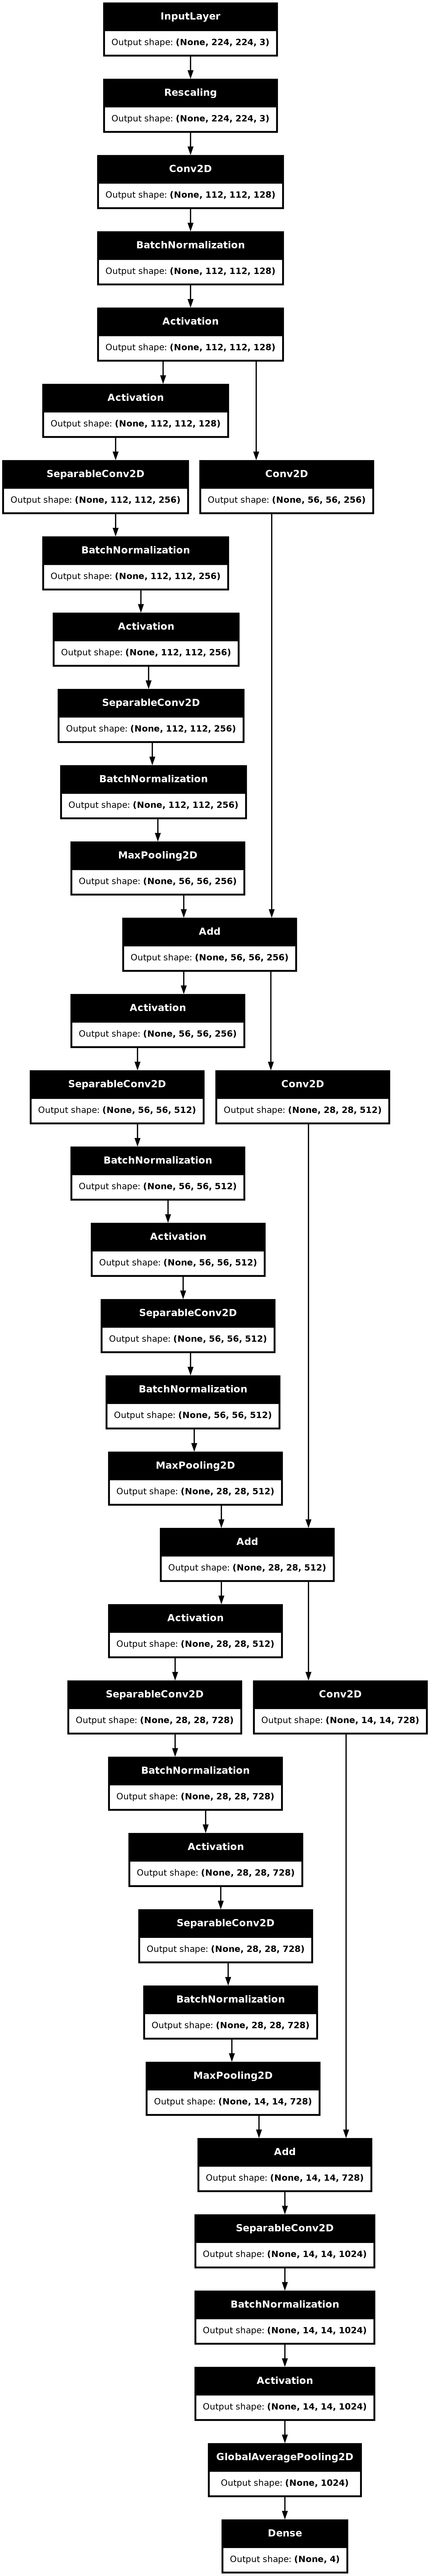

In [12]:
from tensorflow.keras.utils import plot_model
m = get_model()
plot_model(m, to_file="model_arch.png", show_shapes=True)

## <font style="color:blue">4.6. Training Pipeline</font>


In this function, we bring together all the different functions we've defined so far.

In [13]:
from keras.callbacks import ReduceLROnPlateau

def train_model(
    dataset_config=DatasetConfig(),
    training_config=TrainingConfig(),
    data_augmentation=True,
    print_summary=True,
):

    # Get training and validation datasets.
    train_dataset, valid_dataset = get_data(
        data_root=dataset_config.DATA_ROOT,
        target_size=dataset_config.DATA_SHAPE[:2],
        batch_size=training_config.BATCH_SIZE,
        data_augmentation=data_augmentation,
    )

    for images, labels in valid_dataset:
        print("X Shape:", images.shape, "Y Shape:", labels.shape)
        break
        

    # # Get model
    # model = get_model(num_classes=dataset_config.NUM_CLASSES, input_shape=dataset_config.DATA_SHAPE)

    # # Initialize optimizer
    # optimizer = tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE)

    # # Compile model
    # model.compile(
    #     loss="categorical_crossentropy",
    #     optimizer=optimizer,
    #     metrics=["accuracy"],
    # )

    # Start a context manager using the distributed strategy previously defined.
    # This scope ensures that the operations defined within it are distributed across the available devices as per the strategy.
    with DISTRIBUTE_STRATEGY.scope():
        # Get the model by calling the 'get_model' function.
        model = get_model(num_classes=dataset_config.NUM_CLASSES, input_shape=dataset_config.DATA_SHAPE)

        # Compile the model. This step configures the model for training.
        # 'loss' is set to 'categorical_crossentropy', which is a common choice for classification tasks.
        # 'optimizer' is an Adam optimizer with a specific learning rate from the training configuration.
        # 'metrics' is a list of metrics to be evaluated by the model during training and testing, here it's set to track 'accuracy'.
        model.compile(
           loss="categorical_crossentropy",
           optimizer=tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
           metrics=["accuracy"],
        )


    # Print model summary
    if print_summary:
        model.summary()

    # Get training callbacks
    callbacks = get_callbacks(training_config)
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
    )
    
    # Train model
    training_results = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=training_config.EPOCHS,
        callbacks=[callbacks, reduce_lr],
        shuffle=True
    )

    print("training_results keys:", training_results.history.keys())

    return model, training_results

## <font style="color:blue">4.7. Training</font>

Experiment with:

- `Optimizers` and `learning rate schedulers`(You can  get good results even without a learning rate scheduler.)
- Regularization techniques like Data Augmentation, Dropout, BatchNorm.
- Number of epochs.

In [14]:
training_config = TrainingConfig()

# Tensorboard Log and model checkpoint Setup.
training_config, current_version_name = setup_log_directory(training_config)

Logging at: Logs_Checkpoints/Model_logs/version_0
Model Checkpoint at: Logs_Checkpoints/Model_checkpoints/version_0


In [77]:
# Start training

trained_model, training_results = train_model(
    dataset_config=DatasetConfig(),
    training_config=training_config,
    data_augmentation=False
)

Found 3997 files belonging to 4 classes.
Found 786 files belonging to 4 classes.
X Shape: (32, 224, 224, 3) Y Shape: (32, 4)


Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_17        │ (None, 224, 224,  │          0 │ input_layer_28[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 112, 112,  │      3,584 │ rescaling_17[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_68[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_136      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_137      │ (None, 112, 112,  │          0 │ activation_136[0… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 112, 112,  │     34,176 │ activation_137[0… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_138      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 112, 112,  │     68,096 │ activation_138[0… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_51    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 56, 56,    │     33,024 │ activation_136[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_51 (Add)        │ (None, 56, 56,    │          0 │ max_pooling2d_51… │
│                     │ 256)              │            │ conv2d_69[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_139      │ (None, 56, 56,    │          0 │ add_51[0][0]      │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 56, 56,    │    133,888 │ activation_139[0… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      2,048 │ separable_conv2d

 Total params: 2,734,140 (10.43 MB)

 Trainable params: 2,725,852 (10.40 MB)

 Non-trainable params: 8,288 (32.38 KB)

Epoch 1/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 115s 855ms/step - accuracy: 0.4613 - loss: 1.6010 - val_accuracy: 0.2443 - val_loss: 1.8024 - learning_rate: 0.0010
Epoch 2/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 104s 834ms/step - accuracy: 0.6776 - loss: 0.8698 - val_accuracy: 0.2443 - val_loss: 3.1545 - learning_rate: 0.0010
Epoch 3/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 834ms/step - accuracy: 0.7332 - loss: 0.7149 - val_accuracy: 0.2443 - val_loss: 4.8580 - learning_rate: 0.0010
Epoch 4/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 834ms/step - accuracy: 0.8147 - loss: 0.5305 - val_accuracy: 0.2443 - val_loss: 4.5340 - learning_rate: 1.0000e-04
Epoch 5/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 834ms/step - accuracy: 0.8681 - loss: 0.3980 - val_accuracy: 0.2913 - val_loss: 1.9619 - learning_rate: 1.0000e-04
Epoch 6/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 837ms/step - accuracy: 0.8849 - loss: 0.3581 - val_accuracy: 0.7939 - val_loss: 0.5771 - learning_rate: 1.0000e-05
Epoch 7/35
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 837ms/s

## <font style="color:blue">4.8. Loss and Accuracy Plot</font>

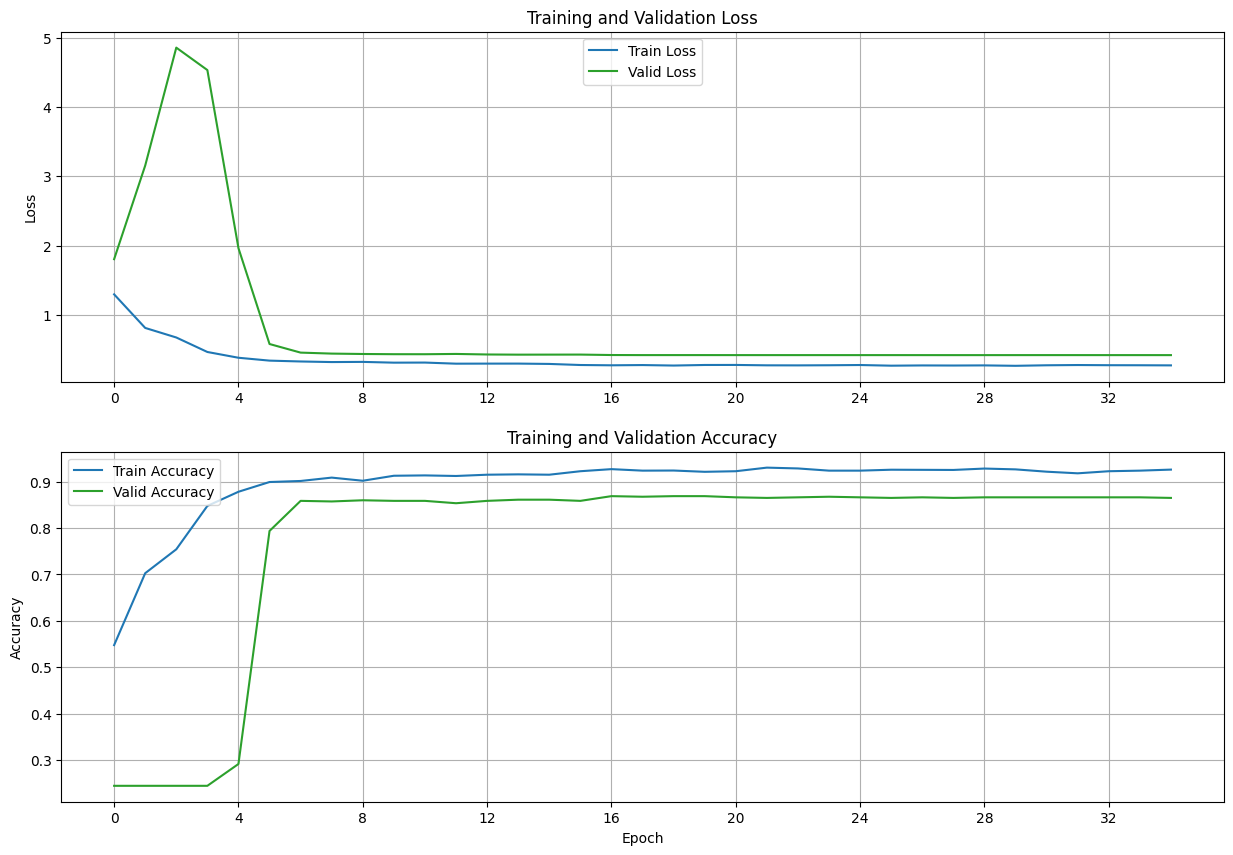

In [78]:
loss = training_results.history["loss"]
accuracy = training_results.history["accuracy"]

val_loss = training_results.history["val_loss"]
val_accuracy = training_results.history["val_accuracy"]

plot_history(
    train_loss=loss,
    train_metric=accuracy,
    val_loss=val_loss,
    val_metric=val_accuracy,
    loss_legend_loc="upper center",
    acc_legend_loc="upper left",
)

# <font style="color:blue">Step 5: Sample Prediction</font>

Show some sample predictions.

## <font style="color:blue">5.1. Reload the Model</font>

A function to help reload the model or the weights saved during training.

In [36]:
def recreate_model(path, load_weights=False, config=DatasetConfig(), **kwargs):
    """
    For reloading trained model
    Args:
        path: current_version checkpoint path
        load_weights: Whether the files saved at path contains model weights
                      or the Entire model configuration
        **kwargs: use to pass additional keyword arguments to the load_model method
    Returns:
        Reinitialized Trained Model
    """

    # Create model architecture
    model = get_model(num_classes=config.NUM_CLASSES, input_shape=config.DATA_SHAPE)

    if(('.keras' in path) or ('.ckpt' in path)):
        model = tf.keras.models.load_model(path, **kwargs)

#     if load_weights:
#         # Load trained model best weights.
#         path = os.path.join(path, "model.ckpt")
#         model.load_weights(path).expect_partial()
#     else:
#         path = os.path.join(path, "model.keras")
#         model = tf.keras.models.load_model(path, **kwargs)

    model.summary()
    return model

### <font style="color:green">Loading latest trained model version</font>

In [37]:
#load_version = current_version_name
#checkpoint_path = os.path.join(training_config.root_checkpoint_dir, load_version) 
checkpoint_path = '/kaggle/input/xception-imageclassification/model_xception_classification.keras'
trained_model = recreate_model(checkpoint_path)

Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_17        │ (None, 224, 224,  │          0 │ input_layer_28[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 112, 112,  │      3,584 │ rescaling_17[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_68[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_136      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_137      │ (None, 112, 112,  │          0 │ activation_136[0… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 112, 112,  │     34,176 │ activation_137[0… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_138      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 112, 112,  │     68,096 │ activation_138[0… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_51    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 56, 56,    │     33,024 │ activation_136[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_51 (Add)        │ (None, 56, 56,    │          0 │ max_pooling2d_51… │
│                     │ 256)              │            │ conv2d_69[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_139      │ (None, 56, 56,    │          0 │ add_51[0][0]      │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 56, 56,    │    133,888 │ activation_139[0… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      2,048 │ separable_conv2d

 Total params: 8,185,846 (31.23 MB)

 Trainable params: 2,725,852 (10.40 MB)

 Non-trainable params: 8,288 (32.38 KB)

 Optimizer params: 5,451,706 (20.80 MB)

## <font style="color:blue">5.2. Running Inference</font>

We’ll be running dummy inference on validation data, and displaying 15 images.

In [58]:
def get_sample_predictions(*, model, dataset, total=15):

    imgs = []
    ground_truths = []
    probs = []
    predictions = []

    idx_to_cls = {0: "cow", 1: "elephant", 2: "horse", 3: "spider"}

    print("Generating Predictions...")
    for data, target in dataset:
        model_predictions = model.predict_on_batch(data)
        cls_predicted = np.argmax(model_predictions, axis=-1)
        cls_probs = np.max(model_predictions, axis=-1)
    
        imgs.extend(data.numpy() / 255.)
        ground_truths.extend(target.numpy())
        predictions.extend(cls_predicted)
        probs.extend(cls_probs)
        
        # Displaying only 15 images 
        if data.shape[0] >= total: 
            break

    plt.style.use("default")
    plt.rcParams["figure.figsize"] = (15, 10)
    fig = plt.figure()
    fig.set_facecolor("white")

    for idx in range(total):

        plt.subplot(3, 5, idx + 1)
        img = imgs[idx]
        plt.imshow(img)

        plt.title(f"P:{idx_to_cls[predictions[idx]]}({probs[idx]:.2}), T:{idx_to_cls[ground_truths[idx]]}")
        plt.axis("off")

    fig.savefig("sample_predictions.png")
    plt.show(block=block_plot)
    
    return ground_truths, probs, predictions

Found 786 files belonging to 4 classes.
Generating Predictions...


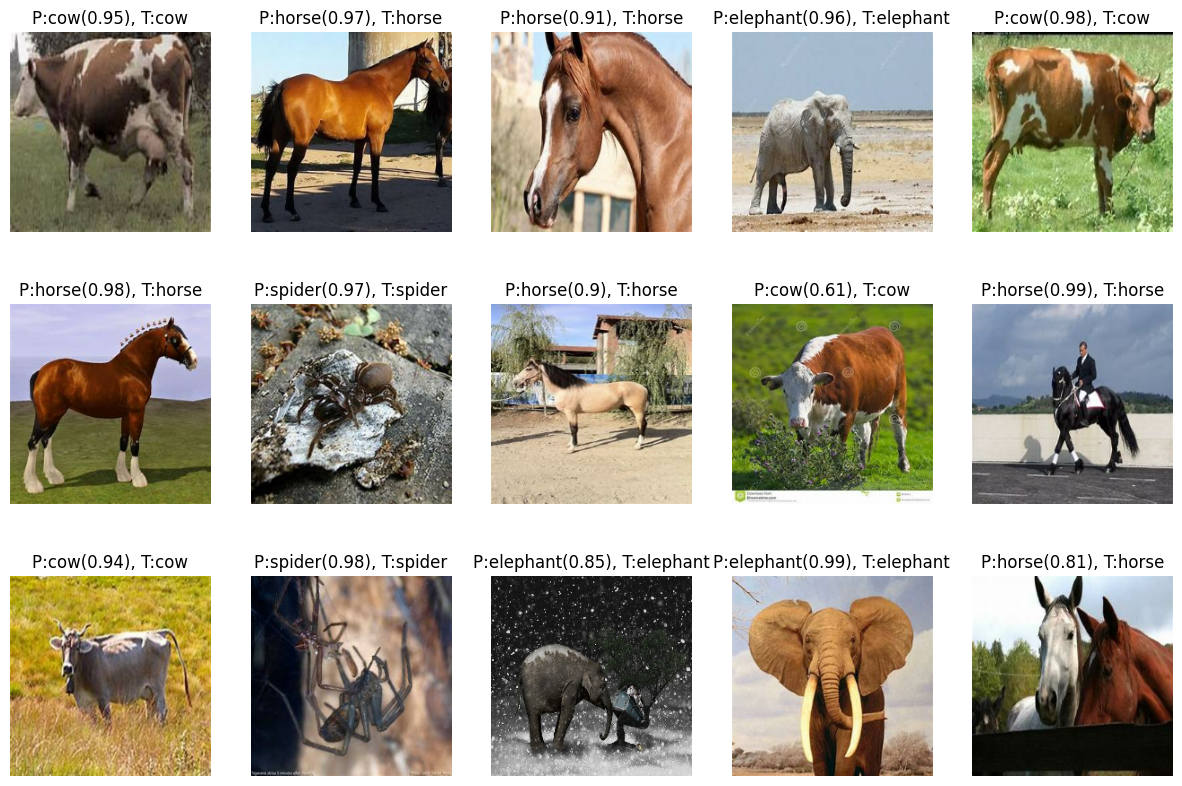

In [59]:
data_config = DatasetConfig()
training_config = TrainingConfig()

valid_path = os.path.join(data_config.DATA_ROOT, "Valid")

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    valid_path, 
    label_mode='int',
    color_mode='rgb', 
    batch_size=training_config.BATCH_SIZE, 
    image_size=data_config.DATA_SHAPE[:2], 
    shuffle=True, # shuffling to show images from all classes
)

ground_truths, probs, valid_predictions = get_sample_predictions(model=trained_model, dataset=valid_dataset)

# <font style="color:red">Step 6. Display Confusion Matrix [5 Points]</font>

Display the confusion matrix (Refer to the earlier lectures on Performance Metrics for this).


This is what the output should look like:

<img src='https://learnopencv.com/wp-content/uploads/2022/02/c4_project_a1_confusion_matrix.png' width=600>


In [69]:
def get_validataset_predictions(*, model, dataset, total=15):

    imgs = []
    ground_truths = []
    probs = []
    predictions = []

    idx_to_cls = {0: "cow", 1: "elephant", 2: "horse", 3: "spider"}

    print("Generating Predictions...")
    for data, target in dataset:
        model_predictions = model.predict_on_batch(data)
        cls_predicted = np.argmax(model_predictions, axis=-1)
        cls_probs = np.max(model_predictions, axis=-1)

        imgs.extend(data.numpy() / 255.)
        ground_truths.extend(target.numpy())
        predictions.extend(cls_predicted)
        probs.extend(cls_probs)

    return ground_truths, probs, predictions

In [70]:
ground_truths, probs, valid_predictions = get_validataset_predictions(model=trained_model, dataset=valid_dataset)

Generating Predictions...


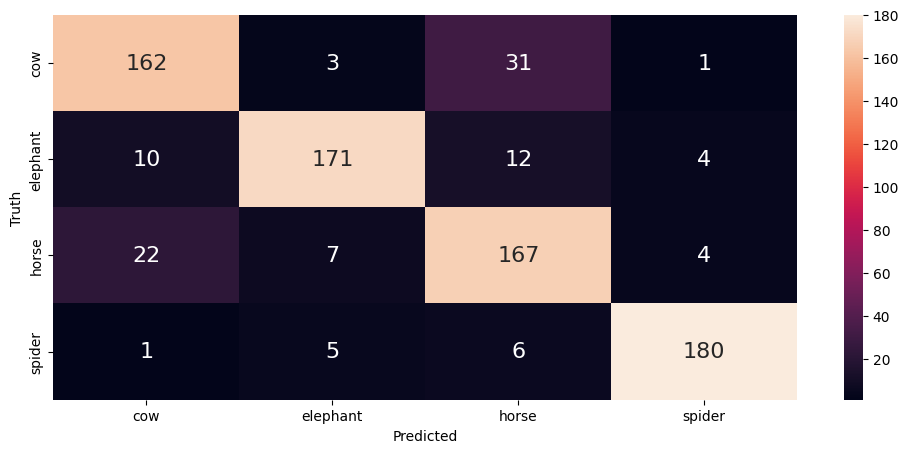

In [72]:
import seaborn as sn

cm = tf.math.confusion_matrix(ground_truths, valid_predictions)

plt.figure(figsize=[12, 5])
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 16}, xticklabels=valid_dataset.class_names,yticklabels=valid_dataset.class_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# <font style="color:red">Step 7. Generate Submission File [5 Points]</font>


**TASK**

1. Generate predictions on the test set.
2. Create a submission `.csv` file.
3. Upload the `.csv` file on Kaggle.


**REFERENCE**
1. **`test.csv`** -  This CSV file contains image IDs for the test set. Read this CSV file to generate predictions for each test image.

2. **`sample_submission.csv`** - Refer to this file to understand the structure of the csv file to be submitted. The sample_submission file is only to be used as reference. <br>
It contains columns:
    1. **`ID`**: same as the test.csv file
    2. **`CLASS`**: which contains random predictions




**<font style="color:red">Use the same column names that are given in the`sample_submission.csv` file.</font>**


In [55]:
import cv2
import pandas as pd
def get_test_predictions(model, datapath, csvpath):
    df = pd.read_csv(csvpath)
#     plt.figure(figsize=(10, 10))
    cls_names = valid_dataset.class_names
    predictions_class = []
    for index, image_id in enumerate(df['ID']):
#         if(index < 30):
            full_img_path = os.path.join(datapath, image_id)
            image = plt.imread(full_img_path, cv2.IMREAD_COLOR)
            if(image.shape[2] == 4):
                image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGR)
            img = cv2.resize(image,(224, 224))
            f_img = np.expand_dims(img, 0)
            #print(image_id)
            prediction = model.predict(f_img)
            predicted_class = cls_names[np.argmax(prediction)]
#             print(predicted_class, image_id)
            predictions_class.append(predicted_class)
#             plt.subplot(5, 6, index + 1)
#             plt.imshow(img)
#             plt.title(predicted_class)
    df['CLASS'] = predictions_class
    df.to_csv('submission_xception.csv', index=False)
    return predictions_class, df

In [57]:
test_path = os.path.join(data_config.DATA_ROOT, "Test")
csv_test_path = '/kaggle/input/opencv-tf-project-1-image-classification-round-3/test.csv'
predictions_class, df_id_class = get_test_predictions(model=trained_model, datapath=test_path, csvpath=csv_test_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

## <font style="color:red">Step 8. Kaggle Submission Score [50 Points]</font>

**For full points, you need to achieve atleast `85%` accuracy on the Public Test leaderboard. If accuracy is less than `80%`, you gain no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, in order to get evaluated for this section.**

**Please share your profile link, user id and score achieved.**

```
URL:
Profile Name:
Points Scored:
```

https://www.kaggle.com/shlokpurani
Shlok Purani
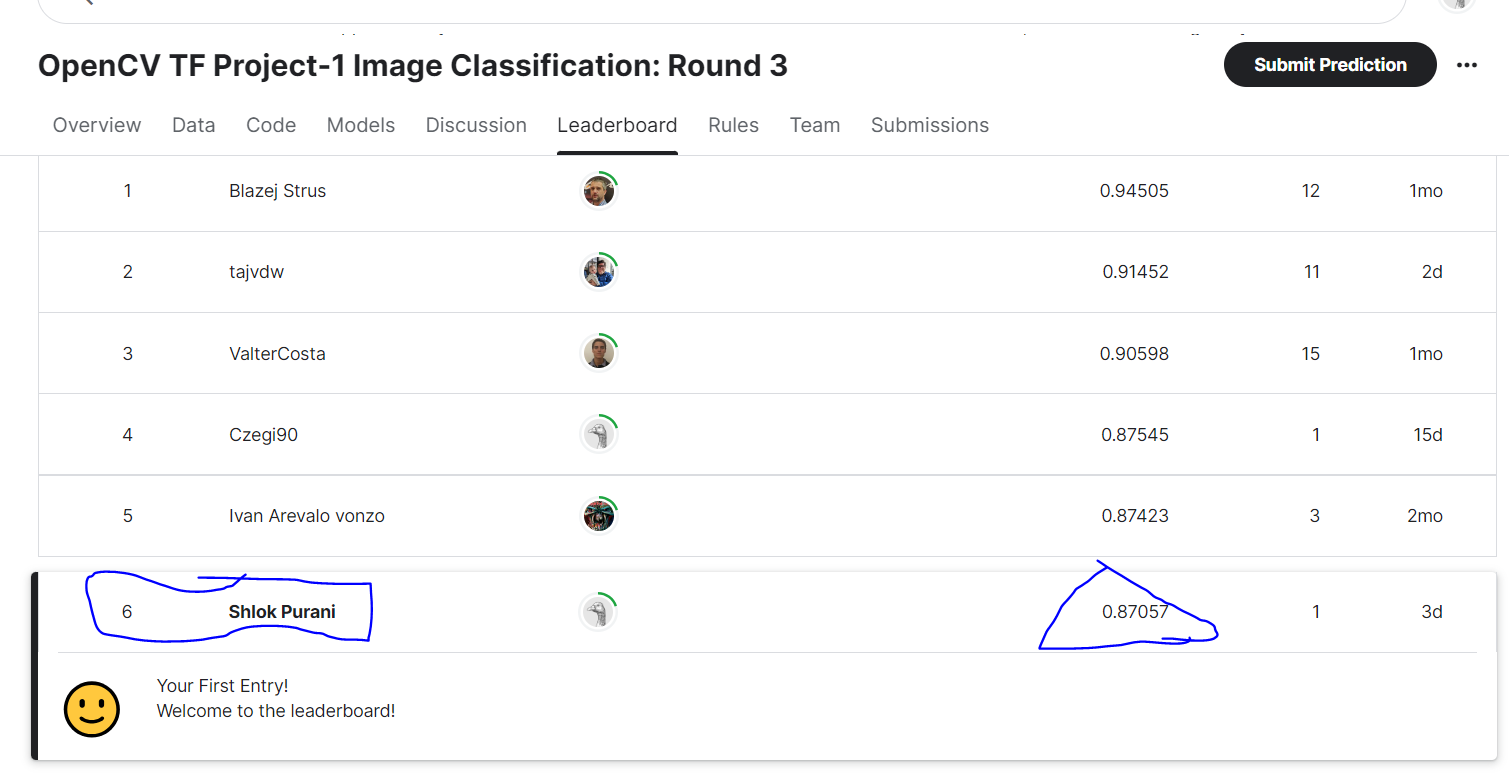

**Upon completing the project, <font style="color:red">upload the notebook to the lab for grading and feedback.</font>**

**<font style="color:red">Please do not make your notebooks public or publish them on the competition page. You only need to submit your notebook to the lab. This is to make sure that students don't copy each other.</font>**